### Prediction with linear model

In this session we will implement models for prediction in high-dimensional environments and study the methodologies involved. 


We will rely on [Scikit-Learn](http://scikit-learn.org/) for the implementation. Scikit-Learn is a python library that provides a number of tools for machine learning. 
See [here](http://scikit-learn.org/stable/documentation.html) for more information and documentation.


### Summary and problem set up

We are interested in predicting a target variable, $y$, using information from a vector of predictor variables, $\mathbf{x} = (x_1,\dots  ,x_p)'$. Our predictions need to be _scored_ by some loss function. A typical choice is the square loss.

The _expected (square) loss_, or the _mean squared error_ of a forecast $f({\bf x})$ is given by

$$ \text{MSE} = \mathbb E\Big[ \Big( y - f({\bf x}) \Big)^2\Big] $$

It can be easily verified that the function that minimizes this particular loss function is $\mathbb E[ y | {\bf x}]$ , the conditional expectation of $y$ given ${\bf x}$. 

Typically, however, we do not know what $\mathbb E[y | {\bf x}]$ looks like, and we need to _learn_, or _estimate_ it from the data. A natural starting point is to _assume_ this function can be reasonably approximated by a linear function.

To fix ideas, we will start from the $p=1$ case and move to the large $p$ case. We will discuss:
+ model selection and evaluation
+ the bias-variance tradeoff
+ model stability
+ overfitting and regularization



In [3]:
# load the relevant modules
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn

### Read the data

We will start studying an artificial dataset to understand the methodology. We will move to real data and applications as we move along.

In [4]:
data = pd.read_csv('https://github.com/barcelonagse-datascience/academic_files/raw/master/data/curve_data.csv')

print(data.shape)
data.head(10)

(10, 2)


,x,y
0,0.0000,0.0528
1,0.1111,0.7980
2,0.2222,0.8486
3,0.3333,0.8719
4,0.4444,0.1732
5,0.5556,-0.3629
6,0.6667,-0.7528
7,0.7778,-0.9985
8,0.8889,-0.6727
9,1.0000,-0.1197


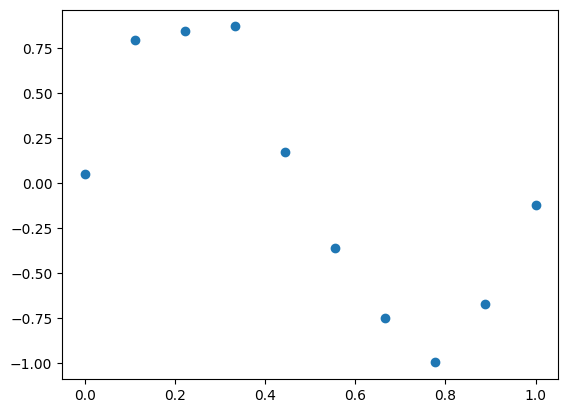

In [5]:
# data visualization
plt.scatter(data['x'], data['y'])

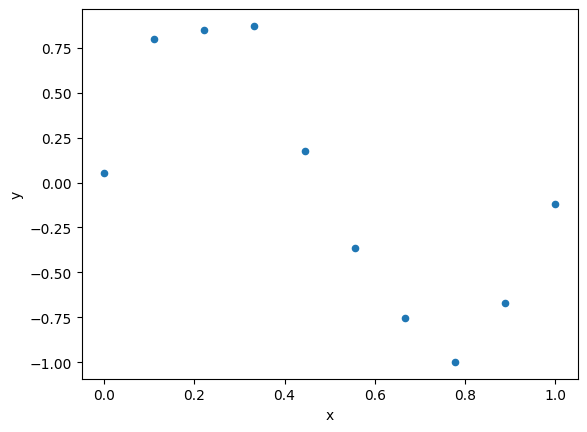

In [6]:
# simple plot to get a feel for the relationship between x and y
# here is a different approch
data.plot(x = 'x',
          y = 'y',
          kind = 'scatter')
plt.show()

### Our first learning function: linear in **X**

We are interested in predicting $y_i$ given a sample size $i = 1,...,n$ and some predictor variables $x_i$. In general, we are interested in finding the function form of the conditional expectation of $y$ given $x$:
$$y_i = f(x_i, \beta) + \mu_i$$

and we call $f(x_i, \beta)$ the learning or regression function. The regression function typically depends on the predictors $x_i$ and some typically unknown parameters $\beta$.

We begin by considering learning functions that are linear in the parameters ($\beta$) and in the predictors ($x_i$'s):
$$ y_i = \beta_0 + \sum_{i=1}^{p}x_i\beta_i + u_i $$
or, equivalently,
$$ y_i = {\bf{x}}_i' {\beta} + u_i $$
where ${\bf{x}_i} = (1, x_{i\,1},\dots,x_{i\,p})'$ and $\beta = (\beta_0,\dots,\beta_{p})'$.

### Estimating our linear function: Least Squares

A typical way to _learn_ the parameters of the model is to estimate them based on some data. Typically, we will solve 
$$ \hat \beta = \arg\min_{\beta} \sum_{i=1}^n\Big( y_i - \bf{x}_i' \beta \Big)^2 $$

where $n$ is the number of observations in our sample. 

Hence, we can state that the line implied by the parameters $\hat \beta$ is the line that best fits our data cloud in the least square sense: it is the line for which the squared deviations are minimal.

Minimizing least squares is a very simple problem. In particular, with some calculus, we can find closed form solutions for $\hat \beta$, or at least express it as the solution to a linear system of equations.

In nice enough environments and denoting by $\bf X$ and $\bf y$ the $n\times p$ matrix of $\bf{x}_1,\dots, \bf{x}_n$ and the vector of $y_1,\dots, y_n$, the closed form solution is $\hat \beta = (\bf{X}'\bf{X})^{-1}(\bf{X}'\bf{y})$.

Moreover, under some conditions, the solution to the least squares problem is equivalent to that obtained by maximum likelihood (for example, under gaussianity of $u_i$).

Remark on notation: bold-face for vectors, otherwise scalars; bold-face capital letters for matrices

Lets see how to estimate a linear model in python.
We first import the relevant tools. For predictive modelling, which is the aim here, `LinearRegression` is good enough. I would not use this for inference though. `statsmodels.api` would be a better choice.

In [7]:
# import the relevant sklearn tools
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

from sklearn.linear_model import LinearRegression

# notice that a LinearRegression is a class
reg = LinearRegression(fit_intercept = True)
# we create an instance of the LinearRegression class

In [8]:
type(reg)

sklearn.linear_model._base.LinearRegression

In [9]:
reg.fit(X = data.x,
        y = data.y)

ValueError: Expected 2D array, got 1D array instead:
array=[0.     0.1111 0.2222 0.3333 0.4444 0.5556 0.6667 0.7778 0.8889 1.    ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [10]:
# the error shows us that there is a problem of the data format
# in fact, sklearn prefers numpy arrays to pandas series
y = data.y.values.reshape(10,1) # to column vector
X = data.x.values.reshape(-1,1) # the same with different syntax

y.shape, X.shape


((10, 1), (10, 1))

In [11]:
data.y.values.reshape(2,-1) # reshape to 2 rows and random columns

array([[ 0.0528,  0.798 ,  0.8486,  0.8719,  0.1732],
       [-0.3629, -0.7528, -0.9985, -0.6727, -0.1197]])

In [12]:
# we have previouly created the reg instance of a LinearRegression class.
# now, we use it to fit a model

reg.fit(X = X, y = y)
reg.coef_, reg.intercept_

(array([[-1.44510598]]), array([0.70634299]))

### Predicting new data

We will compute the learning function $f(x, \hat \beta)$, on some test data. That is, given our estimates $\hat \beta$(from the regression), we will compute $f(x_i, \hat \beta)$, for some (unseen, a.k.a test) $x_i$

In [13]:
# create the new points
X_test = 0.01*np.arange(101).reshape(-1, 1)
X_test.shape

(101, 1)

In [14]:
yhat_test = reg.predict(X_test)
yhat_train = reg.predict(X)

What should we expect from this exercise? Well, we estimated the parameters of a linear model, so we expect our predictions to be linear in X_new.

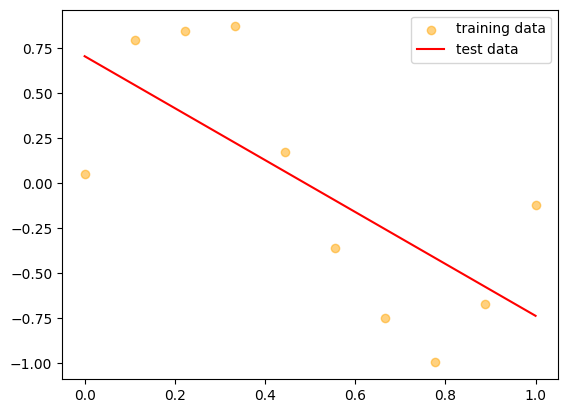

In [15]:
# plot the data
plt.figure()

# plot the training data
plt.scatter(X, y,
            c = 'orange',
            label = 'training data',
            alpha = 0.5)

# plot the test data
plt.plot(X_test, yhat_test,
         c = 'red',
         label = 'test data')
plt.legend()
plt.show()

This is the line that best fits our data, according to our model...

### A more flexible learning function: linear in parameters and features, nonlinear in input

Clearly, a linear regression function is not able to capture the patterns in our curve data. We need a more flexible learning function:


$$ y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \ldots +\beta_n x_i^{p} $$

We have added to our linear model _nonlinear_ transformations of our input $x$.

This is a constructive perspective: we are creating **features**,  new input variables that are transformations of the original ones. In the above construction, if we let the vector of features for the $i$ th data point be 

$$ {\bf  F}_i =(1,x_i,x_i^2,\ldots,x_i^{p})'$$

then 

$$ f(x_i,\beta) =  {\bf  F}_i ' \beta$$

Notice that we now have $p+1$ predictors, even though $x$ is 1-dimensional. The choice of polynomial features is simply for illustration.

In [16]:
# polynomial features are so common that sklearn has a built in function for constructing them
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

from sklearn.preprocessing import PolynomialFeatures as plf
# the argument specifies the polynomial order, here we choose up to power 3
F_med_train = plf(3).fit_transform(X) # F stands for feature matrix
F_med_train # notice that the intercept is now added by default (x^0)

array([[1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.1111    , 0.01234321, 0.00137133],
       [1.        , 0.2222    , 0.04937284, 0.01097065],
       [1.        , 0.3333    , 0.11108889, 0.03702593],
       [1.        , 0.4444    , 0.19749136, 0.08776516],
       [1.        , 0.5556    , 0.30869136, 0.17150892],
       [1.        , 0.6667    , 0.44448889, 0.29634074],
       [1.        , 0.7778    , 0.60497284, 0.47054787],
       [1.        , 0.8889    , 0.79014321, 0.7023583 ],
       [1.        , 1.        , 1.        , 1.        ]])

In [17]:
# we first fit our model
reg_med = LinearRegression(fit_intercept = False) # we already have a column of 1's, hence we remove intercept

# then we use it to create predictions. Note that we use the previously generated test data
reg_med.fit(X = F_med_train, y=y) # fit the new model
yhat_med_train = reg_med.predict(F_med_train) # prediction on the training data

# create predictions. Note that we use the previously generated test data
F_med_test = plf(3).fit_transform(X_test)
yhat_med_test = reg_med.predict(F_med_test)

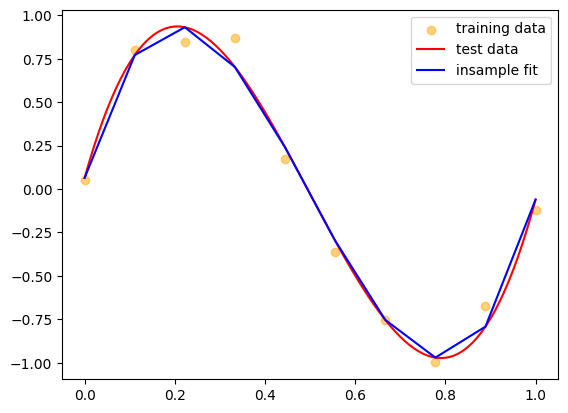

In [18]:
# plot 
plt.figure()

# plot the original data
plt.scatter(X, y,
            c = 'orange',
            label = 'training data',
            alpha = 0.5)

# plot the test data and predicting data
plt.plot(X_test, yhat_med_test,
         c = 'red',
         label = "test data")

# plot the original predictor and in sample prediction 
plt.plot(X, yhat_med_train,
         color = 'blue',
         label = 'insample fit')

plt.legend()
plt.show()

In [19]:
F_large_train = plf(9).fit_transform(X)
F_large_test = plf(9).fit_transform(X_test)

# estimate the model
reg_large = LinearRegression(fit_intercept = False)
reg_large.fit(X = F_large_train, y = y)

# predictions on training and test sample
yhat_large_training = reg_large.predict(F_large_train)
yhat_large_test = reg_large.predict(F_large_test)

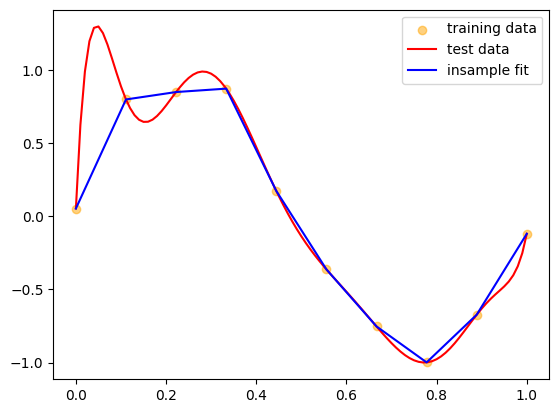

In [20]:
plt.figure()
plt.scatter(X, y,
            color = 'orange',
            label = 'training data',
            alpha = 0.5)
plt.plot(X_test, yhat_large_test,
         color = 'red',
         label = 'test data')
plt.plot(X, yhat_large_training,
         color = 'blue',
         label = 'insample fit')

plt.legend()
plt.show()

It looks like we are _overfitting_ our data.
If we have 10 data points and 10 parameters to estimate, we will quite clearly fit perfectly in sample (the blue line perfectly lines up with the orange points).
However, _in between_ our data points, we may not do a good job at predicting.

### Model evaluation

There are many ways to evaluate the quality of our model. Perhaps the most standard is the **square of the correlation coefficient** between our predictions and the realized values. This squared correlation coefficient is used so frequently that it has a name: R-squared. We can write it as follows

$$ \text{R-squared} = 1 - {\sum_{i=1}^n (y_i - {\bf x}_i'\hat\beta)^2 \over \sum_{i=1}^n (y_i - \bar y)^2}= 1 - {SSR \over TSS}$$

Clearly, large R-squared is equivalent to a small **sum of squared residuals** (SSR: sum of squared residuals, TSS: total sum of squares). The better our models, the smaller the sum of squared residuals.

Lets plot our data and the predictions implied by the least squares solution. 

Text(0.5, 1.0, 'R-squared for the medium model is 1.000')

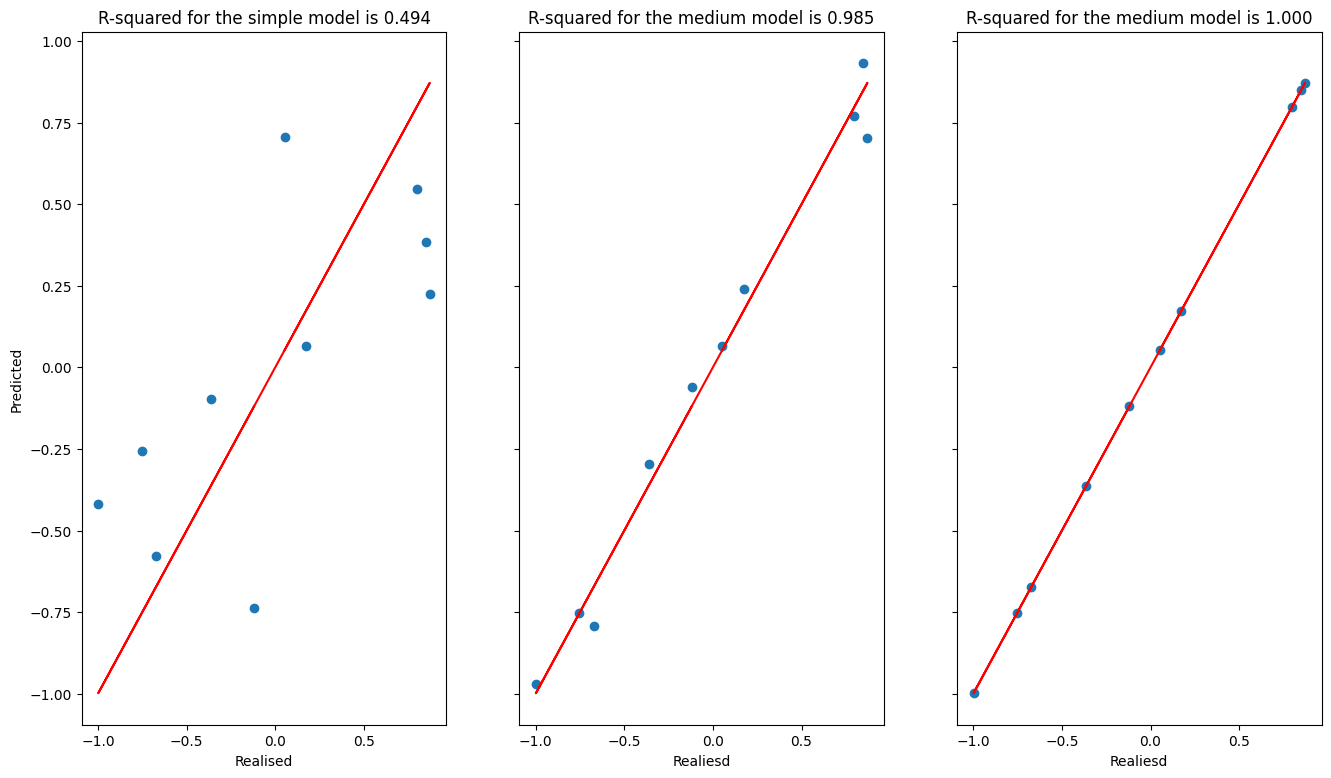

In [21]:
# plot predicted vs observed values for the simple linear model
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, 
                                    figsize = (16, 9),
                                    sharey = 'row')

ax1.scatter(x = y, y = yhat_train)
ax1.set_ylabel('Predicted')
ax1.set_xlabel('Realised')
ax1.plot(y, y, c = 'red')
rho1 = pd.Series(y[:,0]).corr(pd.Series(yhat_train[:,0]))
ax1.set_title("R-squared for the simple model is %.3f" % rho1**2)

ax2.scatter(x = y, y = yhat_med_train)
ax2.set_xlabel('Realiesd')
ax2.plot(y, y, c = 'red')
rho2 = pd.Series(y[:, 0]).corr(pd.Series(yhat_med_train[:,0]))
ax2.set_title('R-squared for the medium model is %.3f' % rho2**2)

ax3.scatter(x = y, y = yhat_large_training)
ax3.set_xlabel('Realiesd')
ax3.plot(y, y, c = 'red')
rho3 = pd.Series(y[:, 0]).corr(pd.Series(yhat_large_training[:,0]))
ax3.set_title('R-squared for the medium model is %.3f' % rho3**2)

What is happening? We are computing the **insample** fit. As we add more parameters, our model becomes more flexible and the **insample** fit increases. In fact, when we have $p=n$, we achieve perfect fit. So the insample R-squared is _too optimistic_.

In general, we are interested in predicting points that we have not yet seen. We need the R-squared to be informative of how our model would perform in unseen data.

Statistically speaking, letting $(x^*,y^*)$ be a randomly chosen *test* points from the same phenomenon that has generated the *training data* $(x_i,y_i),i=1,\ldots,n$, we are interested in reliable estimates of

+ Mean Squared Error (MSE):

$$ \text{MSE} = \mathbb E\Big[\Big(y^* - {\bf x^*}'\hat\beta\Big)^2\Big], \text{ and }$$ 

+ Squared correlation between $y^*$ and $\hat f_n (\bf x^*)$:

$$ R^2 = Cor (y^*,{\bf x^*}'\hat\beta)^2$$

Up to now, we simply replaced the population expectation with the sample averages over the training data. 

However, we just saw that the insample version of these objects is too optimistic by construction.

Lets consider instead the **leave-one-out cross-validation estimator**. The intuition is very simple.
Instead of using **all** our data to estimate the model, we:

+ Use all data points but the $i$ th to estimate $\hat\beta_{-i}$

+ Using the estimated $\hat\beta_{-i}$, compute the prediction for the ("unseen") $i$ th training data point: 

$$ {\bf x}_i \hat \beta_{-i}$$

+ Estimate the MSE or $R^2$ on the _hold out_ sample (in this case, the $i$ th observation)

$$(y_i - {\bf x}_i \hat \beta_{-i})^2$$

+ We can do this for each data point $i$ and then average the estimates: 

$${1 \over n} \sum_{i=1}^n (y_i - {\bf x}_i \hat \beta_{-i})^2$$ 

We can implement this ourselves - or use some `sklearn` functions too.

In [22]:
from sklearn.model_selection import cross_val_predict as cvp
# CV stands for cross validation
yhat_cv = cvp(reg, X, y, cv = 10) # this is leave one out CV when cv=10 and we set cv=10 because n=10
yhat_med_cv = cvp(reg_med, F_med_train, y, cv = 10) 
yhat_large_cv = cvp(reg_large, F_large_train, y, cv = 10)

Text(0.5, 1.0, 'LOOCV R-squared for the large model is 0.01')

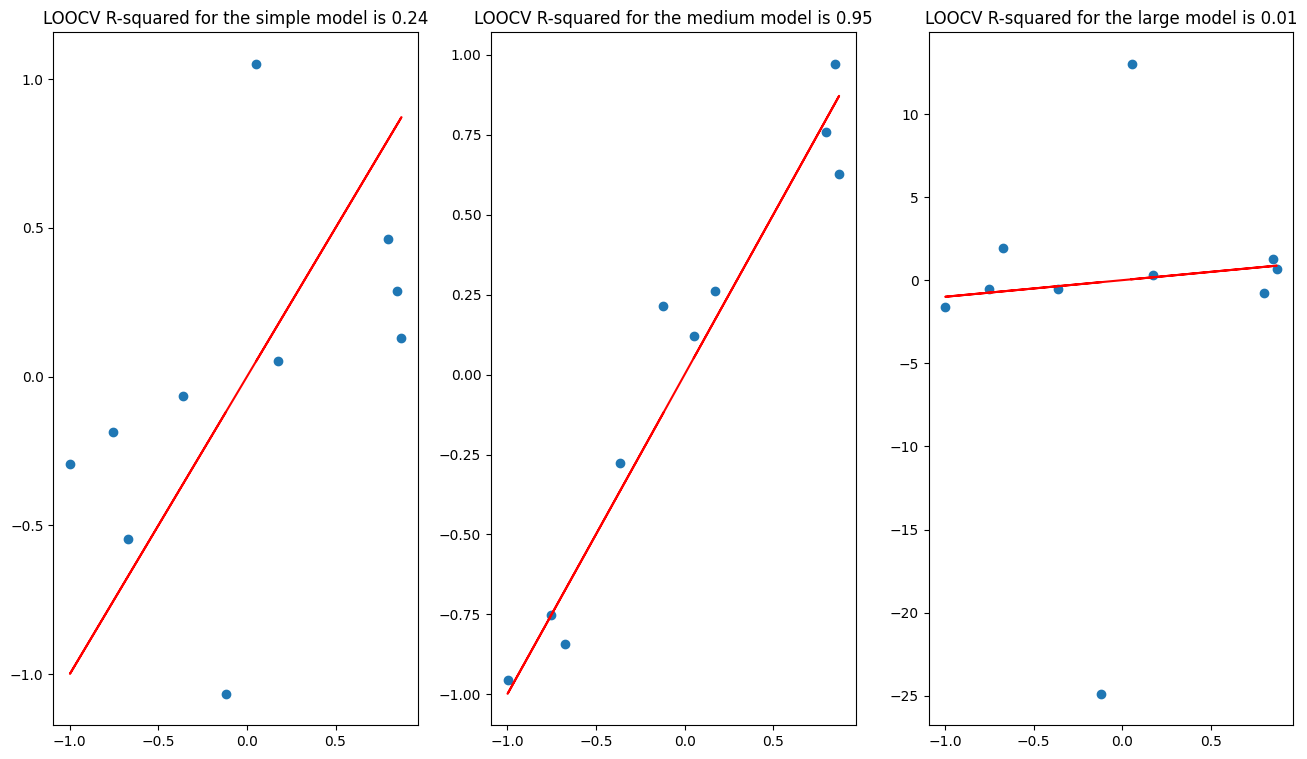

In [23]:
# plot predicted vs observed values
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 9))

ax1.scatter(x = y, y = yhat_cv)
ax1.plot(y, y, c = 'red')
rho1 = pd.Series(y[:,0]).corr(pd.Series(yhat_cv[:,0]))
ax1.set_title('LOOCV R-squared for the simple model is %.2f' % rho1**2)

ax2.scatter(x = y, y = yhat_med_cv)
ax2.plot(y, y, c = 'red')
rho2 = pd.Series(y[:,0]).corr(pd.Series(yhat_med_cv[:,0]))
ax2.set_title('LOOCV R-squared for the medium model is %.2f' % rho2**2)

ax3.scatter(x = y, y = yhat_large_cv)
ax3.plot(y, y, c = 'red')
rho3 = pd.Series(y[:,0]).corr(pd.Series(yhat_large_cv[:,0]))
ax3.set_title('LOOCV R-squared for the large model is %.2f' % rho3**2)

If we compare our Cross-Validated estimates with the insample estimates, we get substantial differences.

It becomes very clear that the heavily parametrized model is very good insample, but very bad out of sample. 
Simple models may have a smaller R-squared in sample, but their performance is more stable.

This leads us into the next topic:

### The bias-variance trade off in Statistics and Machine Learning

+ *Procedures* with *few degrees of freedom* are stable but the learning function they estimate can be systematically far off from the optimal one (**bias**). They would have comparable R-squared and leave-one-out CV R-squared


+ *Procedures* with *high degrees of freedom* are overly sensitive to training data (which induces higher **variance**) but their flexibility allows them to approximate well the target series, and reduce bias. They would have near-1 R-squared and near-0 leave-one-out CV R-squared 

It is important to understand that these properties involve **both the model and the loss function** .
In fact, the MSE can be written as the sum of the variance and the (squared) bias. 

This opens a lot of possibilities! In particular, we can trade-off bias and variance. 

The following figure, taken from Bishop, shows the estimated root mean squared error - blue is in-sample, red is analogous to leave-one-out CV - for increasing values of $p$ (denoted by $M$ in the fig). 

<img src="https://github.com/barcelonagse-datascience/academic_files/raw/master/images/bishop_overfit.png">

We want **algorithms that can strike a good bias-variance tradeoff**!

The remaining of this lecture is devoted to:

1. Studying such algorithms: e.g. the LASSO; they use the same linear-in-features model but a different loss function
2. Discussing how to estimate the MSE from data; we will revisit CV.

## A framework for good predictive algorithms: shrinkage methods

We now study *algorithms* that achieve a good bias-variance tradeoff and allow us to fit models with a very large number of features, potentially larger than the number of observations. The key structure that such algorithms try to exploit is **sparsity**, i.e., situations in which only a small number of features are relevant to get good predictions. 

If we **knew** what such features were, we could just select those and be done. But we typically do not know what they are and have to settle for a second best. One route is called **best subset selection** , meaning that we attempt to choose the best subset of size $k$ out of our original $p$ predictors. Without going into detail, I will just remark that this is a **really** hard and computationally demanding problem, so we typically go another route (although some alternatives exist: random subset, random projections,...).


These *algorithms* use the *same linear models* we have seen before. But they use slightly different loss functions. 

Recall that our methods so far focused on minimizing the square loss, _i.e_

$$\sum_{i=1}^n (y_i - \bf x_i' \beta)^2$$ 

The class of algorithms we discuss now are **shrinkage methods**; they are based on adapting the loss function to *shrink* coefficients in a meaningful direction. It turns out shrinking towards 0 is often a good choice (think of the sparsity notion that we just introduced), and we look for parameters such that

$$ \beta^g = \arg\min_\beta \sum_{i=1}^n (y_i - \bf x_i' \beta)^2 + \lambda \sum_{j=1}^{p} g(\beta_j)$$ 


where $g(\beta_j)$ is a **penalty** term, that penalizes $\beta_j$ by $\lambda\geq0$ when $\beta_j \neq  0$; recall that $\beta_j = 0$ means that feature $j$ (e.g., $j-1$ polynomial order, in the current case) is dropped from the model.


Procedures based on this type of loss functions are broadly called _penalized regression_. 
The following are some common examples of penalties - and the names the corresponding algorithms are known with: 

+ LASSO: $g(\beta) = |\beta|$ --> Shrinkage and Selection

+ ridge regression: $g(\beta) = \beta^2$ --> Shrinkage (but no _hard_ 0s!)

+ Elastic Net: If variables are strongly correlated, LASSO picks _some_ of them. Ridge, on the other hand, tends to shrink the coefficients of correlated variables to each other. The _Elastic Net_ is a compromise:

$$ g(\beta,\alpha) = \sum_{j=1}^p(\alpha|\beta_j| + (1-\alpha)\beta_j^2)$$
the first term encourages a sparse solution and the second encourages highly correlated features to be averaged.

+ The elastic net performs Shrinkage and Selection, and strikes a balance between the hard selection of the lasso and the averaging of similar coefficients of Ridge.

All these models can be cast as restricted optimization problems. For instance, Ridge can be cast as 
$$ \beta^{Ridge} = \arg\min_{\beta} \sum_{i=1}^n\Big( y_i - \bf x_i' \beta \Big)^2$$
subject to  $$  \sum_{j=1}^{p} \beta_j^2 < t $$


Lasso can be cast as 
$$ \beta^{LASSO} = \arg\min_{\beta} \sum_{i=1}^n\Big( y_i - \bf x_i' \beta \Big)^2$$
subject to  $$  \sum_{j=1}^{p} |\beta_j| < t $$

In both cases, there is a one-to-one correspondence between $\lambda$ and $t$.

In case of orthonormal predictors, we have that the coefficients for the lasso are given by

$$ \hat \beta_j^{Ridge} = \hat \beta_j/(1 + \lambda), \hspace{2em} \text{ and } \hspace{2em} \hat \beta_j^{LASSO} = \text{sign}(\hat \beta_j)(|\hat \beta_j - \lambda|)_+ $$

A figure to help us see what is happening

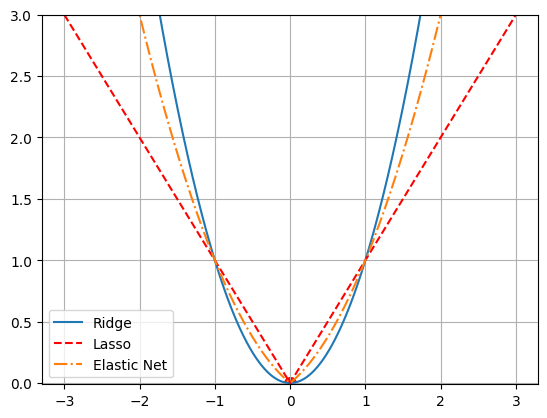

In [26]:
beta = np.arange(-3, 3, 0.01)
ridgePen = (beta**2)
lassoPen = abs(beta)
elnetPen = 0.5*ridgePen + 0.5*lassoPen

plt.grid()
plt.plot(beta, ridgePen, label = 'Ridge')
plt.plot(beta, lassoPen, 'r--', label = 'Lasso')
plt.plot(beta, elnetPen, '-.', label = 'Elastic Net')
plt.scatter(0, 0, s = 70, c = 'r', marker = 'o')
plt.ylim(-0.01,3)
plt.legend()
plt.show()

Some remarks: 

+ Feature standardization: 

a) Different coefficients are penalized in the same way: this only makes sense if the different coefficients have similar magnitudes.
        
b) Penalized likelihood algorithms require that the features have been standardized to have comparable scales. We often subtract the sample mean and divide by the standard deviation across replications

+ The role of $\lambda$:
    + This **hyperparameter** (a.k.a *tuning parameter*) allows us to trade bias with variance, creating a continuum of mean squared errors along which we try to choose an optimal $\lambda$. 
    + $\lambda \to 0$ leads to small bias/large variance (there is no penalty), $\lambda \to \infty$ to large bias/small variance (the model is effectively only estimating the constant term)
    + Ridge regression with varying $\lambda$ s: 
    <img src="https://github.com/barcelonagse-datascience/academic_files/raw/master/images/bias_variance_bishop.png" width="400">

### Lasso in action: the curve data with many many features

In [27]:
# standardisation of input is critical: we will use sklearn to do this
from sklearn.preprocessing import scale as scl

S_large_train = scl(F_large_train)

In [28]:
from sklearn.linear_model import Lasso

# alpha here is the tuning parameter
lasso = Lasso(alpha = 0.00001,      # small penalty
              fit_intercept= False,
              warm_start = True,
              max_iter = 1000000)

lasso_al = Lasso(alpha = 10e6,      # big penalty
                 fit_intercept = False,
                 warm_start = True,
                 max_iter = 1000000)

# application to our data and model
lasso.fit(S_large_train, y)
lasso_al.fit(S_large_train, y)

# see coefficients
print(lasso.coef_)
print(lasso_al.coef_)

np.abs(lasso.coef_).sum(), np.abs(lasso_al.coef_).sum()

[ 0.          2.74603826 -7.13828576  0.22353962  4.56842798  0.
  0.         -0.         -0.         -0.66094287]
[ 0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]


(15.337234489866503, 0.0)

Ridge 


In [29]:
from sklearn.linear_model import Ridge

# alpha here is the tuning parameter
ridge = Ridge(alpha=0.00001,      # small penalty
              fit_intercept=False,
              max_iter=1000000)

ridge_al = Ridge(alpha=10e6,      # big penalty
                 fit_intercept=False,
                 max_iter=1000000)

# apply to our data
ridge.fit(S_large_train, y)
ridge_al.fit(S_large_train, y)

# see coeffients
print(ridge.coef_)
print(ridge_al.coef_)

np.abs(ridge.coef_).sum(), np.abs(ridge_al.coef_).sum()

[[ 0.          2.74670284 -7.1952736   0.84671759  2.54365939  2.17739565
   0.19497954 -0.98800576 -0.6097341   0.02268662]]
[[ 0.00000000e+00 -4.61209036e-07 -4.41019661e-07 -3.80521518e-07
  -3.21617297e-07 -2.71759408e-07 -2.31143516e-07 -1.98363170e-07
  -1.71874805e-07 -1.50357116e-07]]


(17.325155091949835, 2.6278655263001846e-06)

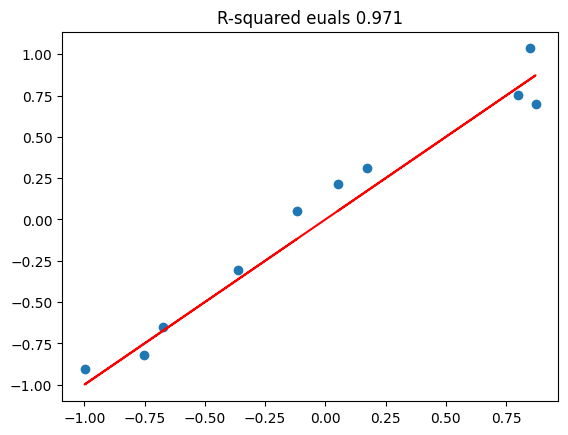

In [30]:
# CV R2
yhat_lasso_cv = cvp(lasso, S_large_train, y , cv=10)

plt.figure()
plt.plot(y, y, c='red')
plt.scatter(x = y, y = yhat_lasso_cv)
rho = pd.Series(y[:,0]).corr(pd.Series(yhat_lasso_cv))
plt.title('R-squared euals %.3f' % rho**2)
plt.show()

### Further insights & observations on LASSO

+ Sparsity: increasing values of $\lambda$ have the effect that an increasing number of estimated coefficients are exactly zero
+ Variable selection: hence, implictly lasso also performs a principled feature selection - but this is not an aspect we will explore here
+ Lets see these properties in action in our example. Lets look at the coefficients for a range of $\lambda$ values

In [31]:
from sklearn.linear_model import lars_path

alphas, _, coefs = lars_path(S_large_train,
                             y[:,0],
                             method='lasso',
                             verbose=True,
                             max_iter=100000)

# sum of absolute coefficients
xx = np.sum(np.abs(coefs), axis=0) 

# standardized by the maximum
xx /= xx[-1]

.

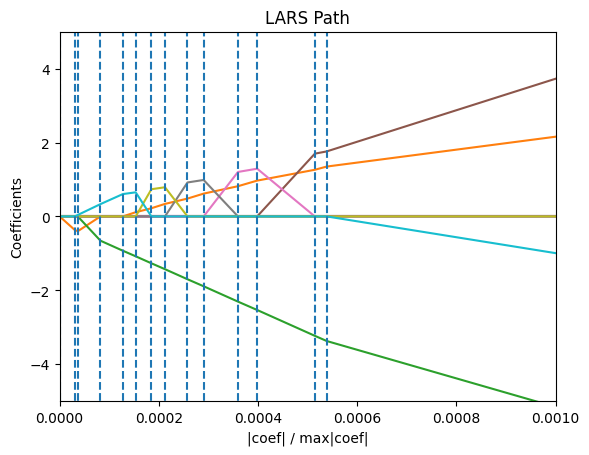

In [37]:

plt.plot(xx, coefs.T)

ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyles='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LARS Path')
plt.axis('tight')
plt.xlim(0,0.001)
plt.ylim(-5,5)
plt.show()

+ Convexity: the loss function is convex; this is because the least squares function is convex (a quadratic function) and the penalty is convex too. This allows very efficient estimation using **convex optimization** algorithms. 
+ A common choice is **coordinate-wise descent**. This is an iterative algorithm that scans through each coefficient and updates it using information about the values of all other coefficients. 
+ For standardized features $\bf x_1,\bf x_2,\ldots$ each coefficient is updated as: 
$$\beta_j \leftarrow \mathcal{S}_{\lambda}\left({1 \over n} \boldsymbol{r}_{-j}^T \bf x_j\right )$$
where $\boldsymbol{r}_{-j}$ is the vector of residuals from the model with $\beta_j = 0$ and the soft-thresholding operator is:
      $$\mathcal{S}_{\lambda}(\beta) = \mathrm{sign}(\beta) \max\{|\beta| - \lambda,0\}$$
+ The fast optimization is a major attraction for the lasso 
+ Coordinate-wise descent is implemented at a cost that grows only linearly in $n$ and $p$: it is a practical solution for Big Data and Big Models  

### Choosing the regularization hyperparameter

Given an estimator of the MSE (*i.e.* LOOCV), we can choose $\lambda$ to hopefully achieve small MSE.
Another possibility is to use a **model selection** criterion. Model selection criteria balance in-sample fit with **model complexity**. 

First, we try leave-one-out CV in our example. 

### Leave-one-out CV selection of $\lambda$ for the curve data

Lets try and do this using the leave-one-out CV we have already discussed. We will try a range of different $\lambda$ s, for each of which we will estimate the MSE by leave-one-out CV, plot the resultant curve and try to identify a good $\lambda$

The procedure is computationally intensive - this will not manifest here where $n=10$

We will use `GridSearchCV` to carry out the outer (grid search and CV) loop

In [39]:
from sklearn.model_selection import GridSearchCV

lasso = Lasso(random_state=0,
              max_iter=3000000)

alphas = np.array([0.000007, 0.00002, 0.00004, 0.00005, 
                   0.00008, 0.0001, 0.00012, 0.00015,
                   0.0002, 0.00025, 0.0003, 0.0004,
                   0.0005, 0.0006, 0.0007, 0.002])

tuning_parameters = [{'alpha': alphas}]

# remember that for tihs dataset this is leave-one-out
n_folds = 10

In [40]:
# create a scorer to evaluate performance

from sklearn.metrics import mean_squared_error, make_scorer
# ALWAYS read carefully documentation. 
# copying here from make_scorer
# greater_is_better: boolean, default=True
# "Whether score_func is a score function (default), meaning high is good, or a loss function, meaning low is good. 
# In the latter case, the scorer object will sign-flip 
# the outcome of the score_func.

mse = make_scorer(mean_squared_error, greater_is_better=False)
clf = GridSearchCV(lasso,
                   tuning_parameters,
                   scoring = mse,
                   cv = n_folds,
                   refit = True)

clf.fit(S_large_train, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
std_error = scores_std / np.sqrt(n_folds)
pd.DataFrame(-scores, alphas)

,0
0.000007,0.031064
0.000020,0.019858
0.000040,0.019463
0.000050,0.018425
0.000080,0.020820
0.000100,0.022439
0.000120,0.024839
0.000150,0.028604
0.000200,0.036120
0.000250,0.045080


In [41]:
# extract the best parameter
clf.best_estimator_

Lasso(alpha=5e-05, max_iter=3000000, random_state=0)

(7e-06, 0.002)

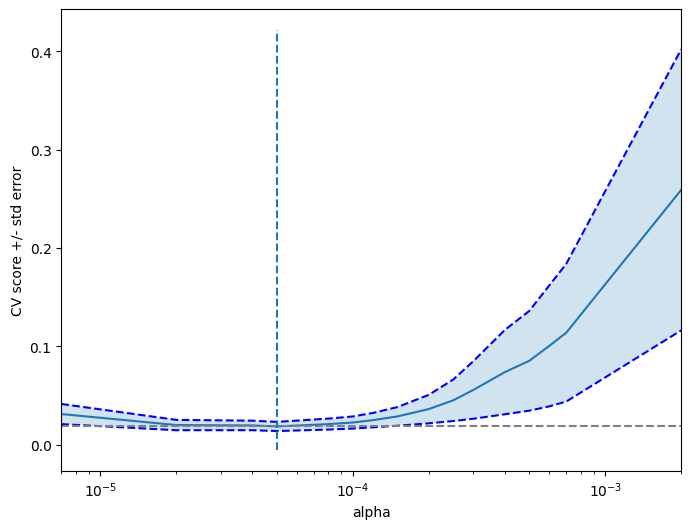

In [53]:
# plot the results
plt.figure(figsize=(8, 6))
plt.semilogx(alphas, -scores)

# plot error lines showing +/-std. errors of the scores
plt.semilogx(alphas, -scores + std_error, 'b--')
plt.semilogx(alphas, -scores - std_error, 'b--')

# alpha = 0.2 controls the translucency of the fill color
plt.fill_between(alphas,
                 -scores + std_error,
                 -scores - std_error,
                 alpha = 0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.min(-scores),
            linestyle = '--',
            color = '0.5',)

plt.vlines(clf.best_params_['alpha'],
           ymin,
           ymax,
           linestyles = 'dashed')

plt.xlim([alphas[0], alphas[-1]])



### Some hints for practitioners


+ Building good predictive models with hundreds or even thousands of features is a real possibility
+ LASSO combines least squares with a penalty for model complexity; it relies on an additional *regularization parameter*
+ Sklearn module `LinearRegression` can be used for predictive modeling. `Lasso` can be used to fit a lasso model for given value of regularization hyperparameter. `lars_path` can return all the possible lasso solutions for all values of the regularization hyperparameter and is a useful tool in exploring the different models
+ The choice of regularization hyperparameter is a model selection problem; you can use both cross validation to estimate the MSE for each possible value of the hyperparameter and use a grid search to identify good values for the hyperparameter - `GridSearchCV` is useful wrapper for this. Less data and computationally intensive method is to use a model selection criterion, e.g. AIC, and a simple formula exists for the lasso
+ For inference with a linear model, i.e., obtaining confidence intervals, p-values etc, `LinearRegression` is  entirely inappropriate. Use other modules, e.g., `statsmodels.api`. 
+ Inference with the output of the lasso model is non-trivial and subject of more advanced material. Although lasso implicitly selects a model by dropping variables, you should not over-interpret the variables that have been selected. Its merit is primary in getting a good predictive model. Lasso is helpful in screening some variables, so it is often used as a first step to be followed by a more formal selection procedure. Generally, these questions fall under the theme of *post-selection* inference